## I. Introduction

Suite aux tests précédents effectués sur des modèles ViT de vit-keras, nous avons voulu vérifier s'il serait possible de réduire encore la taille de notre modèle de Deep Learning en gardant toujours de très bons scores de précision.  
<br>

Nous avons donc décidé de tester des modèles pré-enregistrés proposés par la librairie Keras ayant une bonne précision pour un poids moindre que ViT.  
Ces modèles sont : EfficientNetV2B3, EfficientNetV2S & Xception.
<br>

Ici, nous testerons le modèle Xception.

## II. Chargement des données et preprocessing

### a. Importation des librairies nécessaires

In [28]:
#Importation des librairies de base nécessaires
import os
import io
import gzip
import random
import argparse
from time import time
from datetime import date
from timeit import default_timer as timer

#Importation des librairies de nécessaire à la gestion des données
import numpy as np
import pandas as pd

#Importation des librairies d'affichage de graphiques
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Importation des librairies tensorflow keras nécessaires
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Sequential, datasets, layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2, MobileNetV2, EfficientNetB0
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetB4, EfficientNetV2B3, Xception, InceptionV3
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#Librairies de pre-processing input si existante (enlever le commentaire quand nécessaire)
#from tensorflow.keras.applications.efficientnet import preprocess_input
#from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
#from tensorflow.keras.applications.inception_v3 import preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.xception import preprocess_input

#Librairies additionelles pour la modélisation
from vit_keras import vit
from tensorflow.python.client import device_lib
from sklearn.model_selection import GridSearchCV

### b. Vérification de la configuration tensorflow avec GPU

In [29]:
#Vérification que la version GPU de TensorFlow est bien activée et que le GPU est trouvé
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Récupération du nom du périphérique GPU
devices = device_lib.list_local_devices()
descriptions = [device.physical_device_desc for device in devices]
for desc in descriptions:
    print(desc)

Num GPUs Available:  1

device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### c. Chargement et analyse des données

In [30]:
#Chargement du dataframe créé pour le dataset New Plant Disease
%store -r df_NPD

In [31]:
df_NPD.head()

,Categorie,Plante,Maladie,Saine,Suffixe,Abrev,AbrevMaladie,Rotation,Luminosite,Symetrie,...,Mode,Profondeur de couleur,Moyenne R,Moyenne G,Moyenne B,Taille du fichier,Set,DirPath,FileName,FilePath
0,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,109.957947,129.504242,119.117355,9606,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
1,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,110.123795,129.669220,119.235626,9960,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
2,Apple__Apple_scab,Apple,Apple_scab,0,new30degfliplr.jpg,FREC,Scab,30,0,LR,...,RGB,8,89.325546,109.759598,95.272110,10299,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
3,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,92.044342,125.152634,115.290207,11986,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
4,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,129.272934,125.058243,113.740295,20194,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...


In [32]:
#Récupération des données des set train et valid dans 2 nouveaux dataframes
train_data = df_NPD[df_NPD["Set"] == "train"]
valid_data = df_NPD[df_NPD["Set"] == "valid"]

#Vérification de la répartition des classes
train_counts = train_data["Saine"].value_counts()
valid_counts = valid_data["Saine"].value_counts()

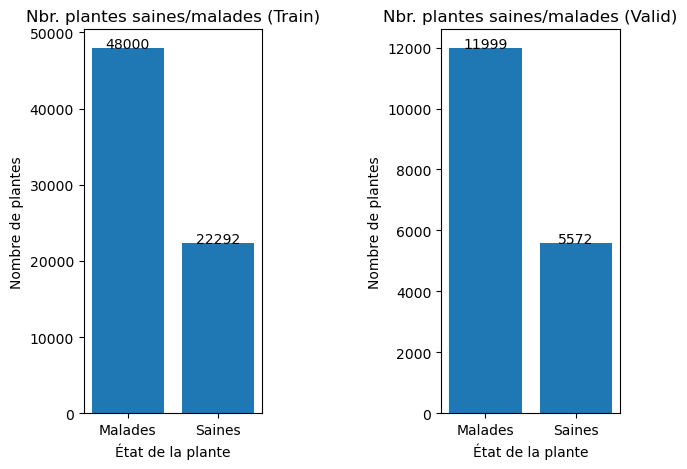

In [33]:
#Graphique pour l'ensemble de validation
plt.subplot(1, 2, 1)
plt.bar(["Malades", "Saines"], train_counts)
plt.xlabel("État de la plante")
plt.ylabel("Nombre de plantes")
plt.title("Nbr. plantes saines/malades (Train)")
plt.text(0, train_counts[0], str(train_counts[0]), ha='center')
plt.text(1, train_counts[1], str(train_counts[1]), ha='center')

#Graphique pour l'ensemble d'entraînement
plt.subplot(1, 2, 2)
plt.bar(["Malades", "Saines"], valid_counts)
plt.xlabel("État de la plante")
plt.ylabel("Nombre de plantes")
plt.title("Nbr. plantes saines/malades (Valid)")
plt.text(0, valid_counts[0], str(valid_counts[0]), ha='center')
plt.text(1, valid_counts[1], str(valid_counts[1]), ha='center')

plt.tight_layout()
plt.subplots_adjust(wspace=1)
plt.show()

In [34]:
print("Pourcentage plantes saines (Train) : ", round((train_counts[1]*100)/train_counts.sum(),2), "%", sep='')
print("Pourcentage plantes malades (Train) : ", round((train_counts[0]*100)/train_counts.sum(),2), "%", sep='')
print("---------------------------------------------")
print("Pourcentage plantes saines (Valid) : ", round((valid_counts[1]*100)/valid_counts.sum(),2), "%", sep='')
print("Pourcentage plantes malades (Valid) : ", round((valid_counts[0]*100)/valid_counts.sum(),2), "%", sep='')

Pourcentage plantes saines (Train) : 31.71%
Pourcentage plantes malades (Train) : 68.29%
---------------------------------------------
Pourcentage plantes saines (Valid) : 31.71%
Pourcentage plantes malades (Valid) : 68.29%


In [35]:
#Remplacement des 0 et des 1 par une chaîne de caractères
train_data["Saine"] = train_data["Saine"].map({0: "Malade", 1: "Saine"})
valid_data["Saine"] = valid_data["Saine"].map({0: "Malade", 1: "Saine"})

C:\Users\flore\AppData\Local\Temp\ipykernel_28376\1419961183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Saine"] = train_data["Saine"].map({0: "Malade", 1: "Saine"})
C:\Users\flore\AppData\Local\Temp\ipykernel_28376\1419961183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data["Saine"] = valid_data["Saine"].map({0: "Malade", 1: "Saine"})


### d. Pré-processing sur les données

In [36]:
#Création du générateur d'image pour Train avec beaucoup de nouvelles modifications bien que les images aient été
#   déjà augmentées. Cela afin d'éviter un sur-apprentissage sur des images trop similaires.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rescale=1./255,
                                   shear_range=0.2, brightness_range=(0.4,1.7),
                                   zoom_range=0.5, rotation_range=40,
                                   width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest')

#Création du générateur d'image pour Valid avec seulement des modifications cohérentes avec ce qu'on pourrait
#   trouver dans la nature.
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255, 
                                   brightness_range=(0.6,1.2),
                                   zoom_range=0.5, rotation_range=40,
                                   horizontal_flip=True, vertical_flip=True)

#Création d'un set sans modification pour afficher les modifications apportées
norm_datagen = ImageDataGenerator(rescale=1./255)

### e. Vérification des modifications apportées sur les images

__Set Train__

Found 70292 validated image filenames belonging to 2 classes.
Found 70292 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


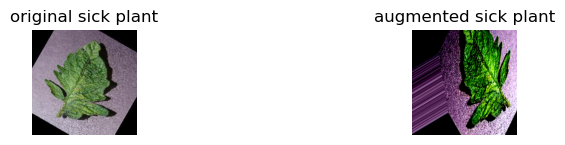

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


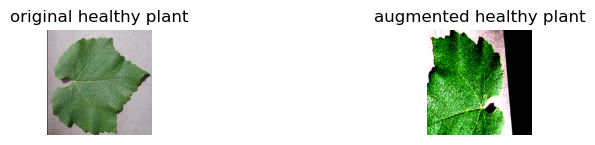

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


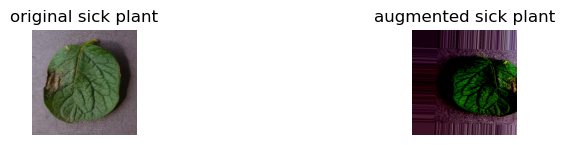

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


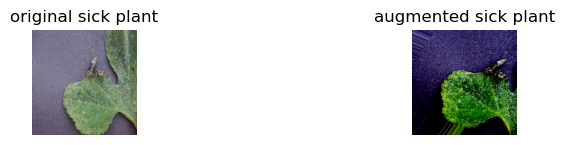

In [37]:
#Affichage de 2x4 images aléatoires
batches_real = norm_datagen.flow_from_dataframe(dataframe=train_data, directory=None, x_col='FilePath', y_col='Saine', 
                                                 target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                 seed=111)

batches_augmented = train_datagen.flow_from_dataframe(dataframe=train_data, directory=None, x_col='FilePath', y_col='Saine', 
                                                      target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                      seed=111)

x_batch_augmented, y_batch_augmented = next(batches_augmented)
x_batch_real, y_batch_real = next(batches_real)

x_batch_augmented_denormalized = x_batch_augmented * 255

for i in range(4):
    plt.figure(figsize=(9, 3))
    
    image_augmented = x_batch_augmented_denormalized[i]
    image_real = x_batch_real[i]
    
    title_add_on = "sick plant"
    if y_batch_augmented[i][1]: title_add_on =  "healthy plant"

    plt.subplot(221)
    plt.imshow(image_real)
    plt.title("original " + title_add_on)
    plt.axis('off')
        
    plt.subplot(222)
    plt.imshow(image_augmented)
    plt.title("augmented " + title_add_on)
    plt.axis('off')

    plt.show()

__Set Valid__

Found 70292 validated image filenames belonging to 2 classes.
Found 70292 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


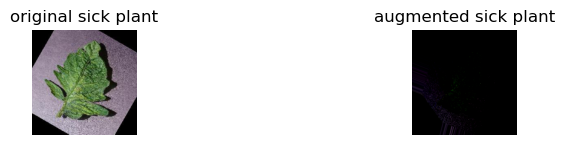

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


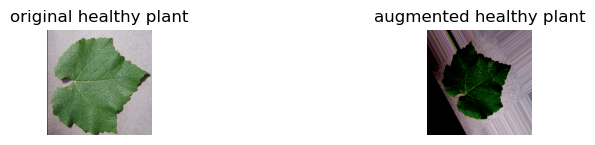

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


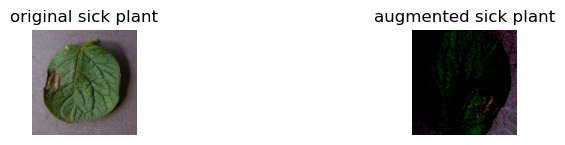

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


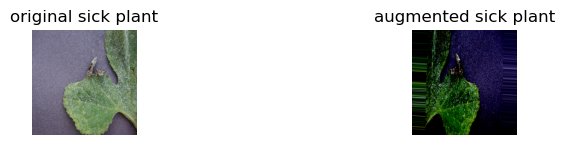

In [38]:
#Affichage de 2x8 images aléatoires
batches_real = norm_datagen.flow_from_dataframe(dataframe=train_data, directory=None, x_col='FilePath', y_col='Saine', 
                                                 target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                 seed=111)

batches_augmented = valid_datagen.flow_from_dataframe(dataframe=train_data, directory=None, x_col='FilePath', y_col='Saine', 
                                                      target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                      seed=111)

x_batch_augmented, y_batch_augmented = next(batches_augmented)
x_batch_real, y_batch_real = next(batches_real)

x_batch_augmented_denormalized = x_batch_augmented * 255

for i in range(4):
    plt.figure(figsize=(9, 3))
    
    image_augmented = x_batch_augmented_denormalized[i]
    image_real = x_batch_real[i]
    
    title_add_on = "sick plant"
    if y_batch_augmented[i][1]: title_add_on =  "healthy plant"

    plt.subplot(221)
    plt.imshow(image_real)
    plt.title("original " + title_add_on)
    plt.axis('off')
        
    plt.subplot(222)
    plt.imshow(image_augmented)
    plt.title("augmented " + title_add_on)
    plt.axis('off')    
    
    plt.show()

### f. Création des datasets

In [12]:
print("Création du set d'entraînement avec le générateur d'image :")
training_set = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,   #None car nous utilisons "FilePath" du dataframe pour charger les images
    x_col='FilePath',   #Colonne contenant les chemins des fichiers
    y_col='Saine',   #Colonne contenant les étiquettes (0 pour malade, 1 pour sain)
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=111
)

print("\nCréation du set de validation avec le générateur d'image :")
valid_set = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory=None,   #None car nous utilisons "FilePath" du dataframe pour charger les images
    x_col='FilePath',   #Colonne contenant les chemins des fichiers
    y_col='Saine',   #Colonne contenant les étiquettes (0 pour malade, 1 pour sain)
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=False
)

Création du set d'entraînement avec le générateur d'image :
Found 70292 validated image filenames belonging to 2 classes.

Création du set de validation avec le générateur d'image :
Found 17571 validated image filenames belonging to 2 classes.


## II. Création du modèle

### a. Récupération du modèle Xception

In [13]:
#Chargement du modèle Xception pré-entraîné
Xception_model = Xception(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(224, 224, 3),
        pooling=None,
        classes=2,
        classifier_activation="softmax"
        )

In [14]:
#Examen des couches du modèle trasnféré pour choisir les nombre de couche à "Freezer"
num_layers = len(Xception_model.layers)
print("Nombre de couches du modèle :", num_layers)

Nombre de couches du modèle : 132


In [15]:
#Examen des couches du modèle trasnféré pour choisir les nombre de couche à "Freezer"
Xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

### b. Création du modèle avec Transfert Learning

In [16]:
#Freeze des poids des couches de base du modèle pré-entraîné
for layer in Xception_model.layers:
    layer.trainable = False

#Unfreeze des poids des 27 dernières couches de base du modèle pré-entraîné (mais pas les BatchNormalization)
##Si pas OK, tester le Unfreeze seulement des 17 dernières couches.
for layer in Xception_model.layers[-27:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

#Création du modèle basé sur Xception
classifier = Sequential()

classifier.add(Xception_model)
classifier.add(GlobalAveragePooling2D())
classifier.add(Dense(256, activation='relu', kernel_initializer="glorot_uniform"))
classifier.add(Dropout(rate=0.2))
classifier.add(Dense(128, activation='relu', kernel_initializer="glorot_uniform"))
classifier.add(Dropout(rate=0.2))
classifier.add(Dense(2, activation='softmax', kernel_initializer="glorot_uniform"))

### c. Création des Callbacks nécessaires

In [17]:
#Création d'un Callback de logging
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        
#Définition de la fonction schedule pour l'utilisation du callback de LearningRateScheduler
def schedule(epoch):
    if epoch < 5:
        return 1e-4
    else:
        return 1e-5

#Définition du chemin et du nom de la sauvegarde des meilleurs poids
cwd = os.getcwd()
savepath = cwd + "\\Saved Models\\Xception-Pre_Final-Best_Weights-ep_{epoch:02d}-vac_{val_accuracy:.2f}.h5"


#Initialisation des différents Callback pour le modèle
time_callback = TimingCallback()

learn_rate_schd = LearningRateScheduler(schedule, verbose = 0)

early_stopping = EarlyStopping(patience=5, min_delta = 0.01, mode = 'min', 
                               monitor='val_loss', verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", patience=3, min_delta= 0.01, 
                                         factor=0.1, cooldown = 4, verbose=1)

checkpoint = ModelCheckpoint(filepath = savepath, monitor = 'val_loss', save_best_only = True,
                            save_weights_only = True, mode = 'min', save_freq = 'epoch', verbose=1)

### d. Compilation du modèle créé

In [18]:
#Utilisation des paramètres ayant donnés les meilleurs résultats pendant les tests
batch_size = 64
epochs = 20
learning_rate = 1e-3

#Compilation du modèle
classifier.compile(optimizer=Adam(learning_rate=learning_rate), 
                   loss='categorical_crossentropy', metrics=['accuracy'])

## III. Entraînement du modèle

In [19]:
t0 = time()

history = classifier.fit(x=training_set, epochs = epochs, 
                         steps_per_epoch = training_set.samples // batch_size, 
                         validation_data=valid_set, 
                         validation_steps=valid_set.samples // batch_size,
                         callbacks = [checkpoint,
                                      time_callback,
                                      reduce_learning_rate,
                                      early_stopping],
                         workers = -1,
                         verbose = True)

tt = time() - t0

print("\nEntraînement réalisé en {} secondes".format(round(tt,3)))

Epoch 1/20
1098/1098 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.7074
Epoch 1: val_loss improved from inf to 0.52020, saving model to C:\Users\flore\Jupyter\Recog_Plant_Disease\Saved Models\Xception-Pre_Final-Best_Weights-ep_01-vac_0.73.h5
1098/1098 [==============================] - 944s 855ms/step - loss: 0.5686 - accuracy: 0.7074 - val_loss: 0.5202 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 2/20
1098/1098 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.7495
Epoch 2: val_loss improved from 0.52020 to 0.41167, saving model to C:\Users\flore\Jupyter\Recog_Plant_Disease\Saved Models\Xception-Pre_Final-Best_Weights-ep_02-vac_0.81.h5
1098/1098 [==============================] - 951s 866ms/step - loss: 0.5054 - accuracy: 0.7495 - val_loss: 0.4117 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 3/20
1098/1098 [==============================] - ETA: 0s - loss: 0.4560 - accuracy: 0.7837
Epoch 3: val_loss improved from 0.41167 to 0.36931, saving mod


Entraînement réalisé en 19035.946 secondes


## IV. Evaluation des performances

### a. Evaluation graphique des performances

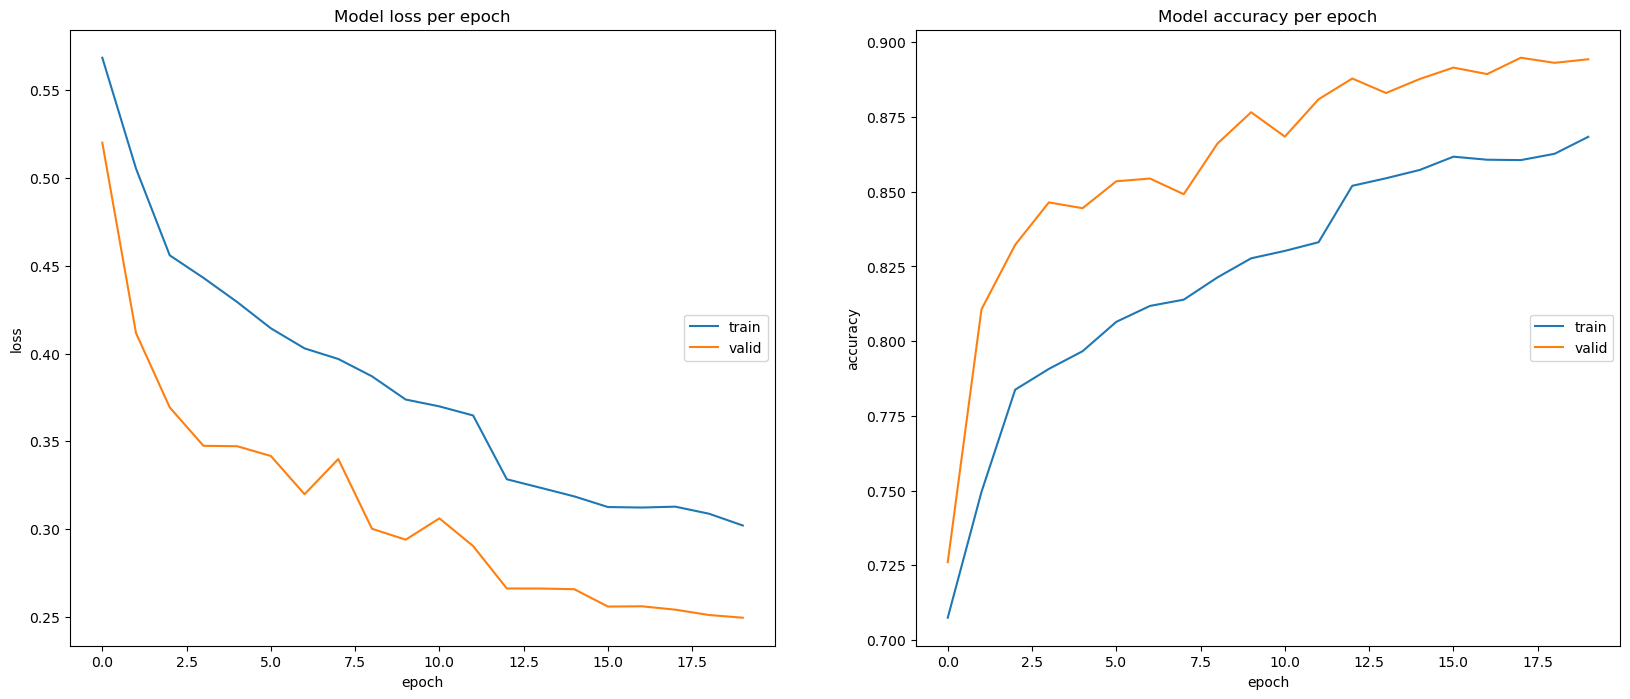

In [20]:
#Vérification de la précision et de la perte lors de l'entraînement
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

#Affichage des graphiques liés à l'entraînement
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.show()

### b. Evaluation sur images de test

__Affichage de base__

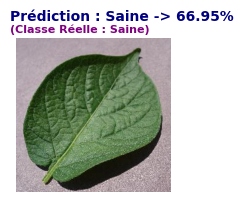

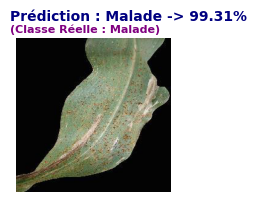

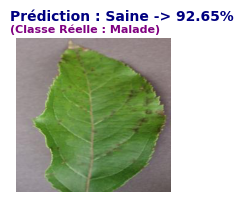

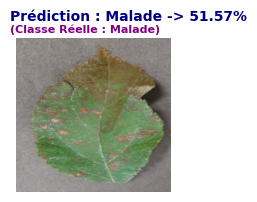

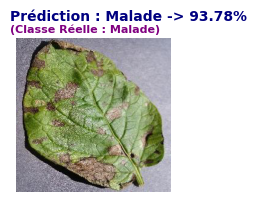

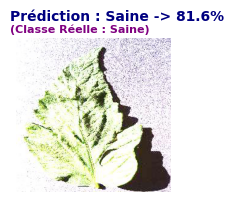

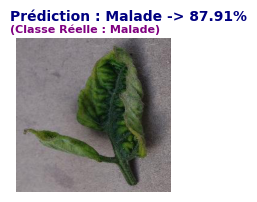

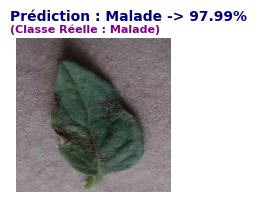

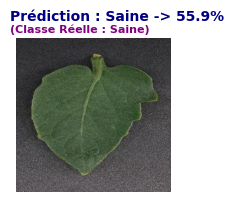

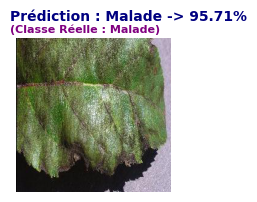

In [21]:
#Chemin du répertoire contenant les images
test_dir = r"C:\Users\flore\Jupyter\Recog_Plant_Disease\Datasets\NPD\test\Test___Pictures_Random"

#Obtention de la liste des noms de fichiers d'images
file_list = os.listdir(test_dir)

#Sélection aléatoire de 10 fichiers d'images
selected_files = random.sample(file_list, 10)

#Boucle pour afficher les images
for file in selected_files:
    file_path = os.path.join(test_dir, file)
    
    #Récupération de la classe réelle (via le nom du fichier)
    if "Healthy" in file:
        real_class = 'Saine'
    else:
        real_class = 'Malade'
    
    #Chargement et prétraitement de l'image
    test_image = image.load_img(file_path, target_size=(224, 224))
    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)
    
    #Prédiction de la classe
    proba = round(100 * classifier.predict(test_image, verbose=0)[0][1], 2)
    if proba < 50:
        plant_state = 'Malade'
        proba = round(100 - proba, 2)
    else:
        plant_state = 'Saine'
    
    #Chargement et affichage de l'image
    img = mpimg.imread(file_path)
    plt.figure(figsize=(7, 2))
    plt.axis('off')
    plt.text(-10, -30, 'Prédiction : ' + plant_state + ' -> ' + str(proba) + '%', color=('Navy'), fontsize=10, fontweight='bold')
    plt.text(-10, -10, '(Classe Réelle : ' + real_class + ')', color=('Purple'), fontsize=8, fontweight='bold')
    imgplot = plt.imshow(img)
    plt.show()

__Affichage amélioré__

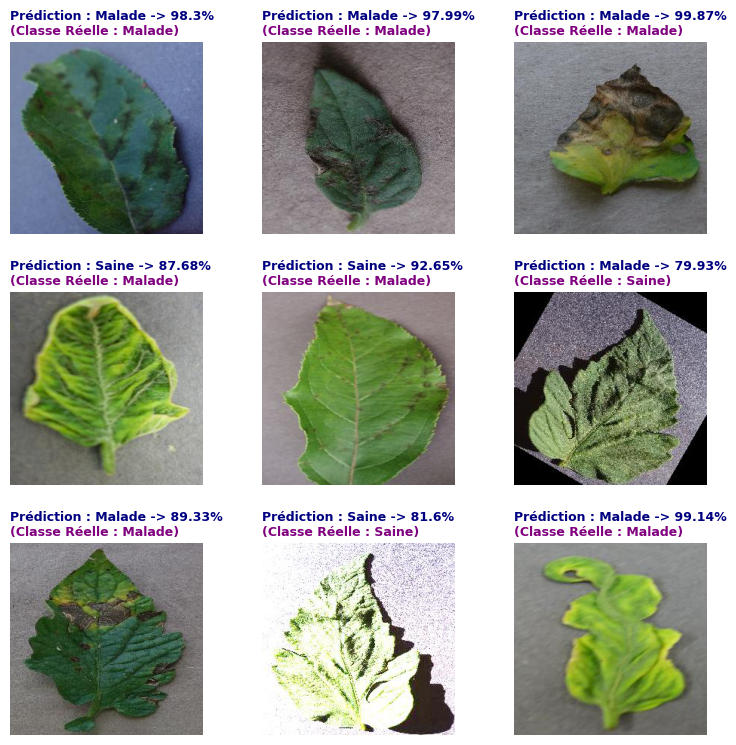

In [22]:
#Chemin du répertoire contenant les images
test_dir = r"C:\Users\flore\Jupyter\Recog_Plant_Disease\Datasets\NPD\test\Test___Pictures_Random"

#Obtention de la liste des noms de fichiers d'images
file_list = os.listdir(test_dir)

#Sélection aléatoire de 9 fichiers d'images
selected_files = random.sample(file_list, 9)

#Configuration des sous-plots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Boucle pour afficher les images
for i, file in enumerate(selected_files):
    file_path = os.path.join(test_dir, file)

    #Récupération de la classe réelle (via le nom du fichier)
    if "Healthy" in file:
        real_class = 'Saine'
    else:
        real_class = 'Malade'

    #Chargement et prétraitement de l'image
    test_image = image.load_img(file_path, target_size=(224, 224))
    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)

    #Prédiction de la classe
    proba = round(100 * classifier.predict(test_image, verbose=0)[0][1], 2)
    if proba < 50:
        plant_state = 'Malade'
        proba = round(100 - proba, 2)
    else:
        plant_state = 'Saine'

    #Chargement et affichage de l'image
    img = mpimg.imread(file_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.text(0, -30, 'Prédiction : ' + plant_state + ' -> ' + str(proba) + '%', color=('Navy'), fontsize=9, fontweight='bold')
    ax.text(0, -10, '(Classe Réelle : ' + real_class + ')', color=('Purple'), fontsize=9, fontweight='bold')

#plt.tight_layout()
plt.show()

__Spécial Vérifications__

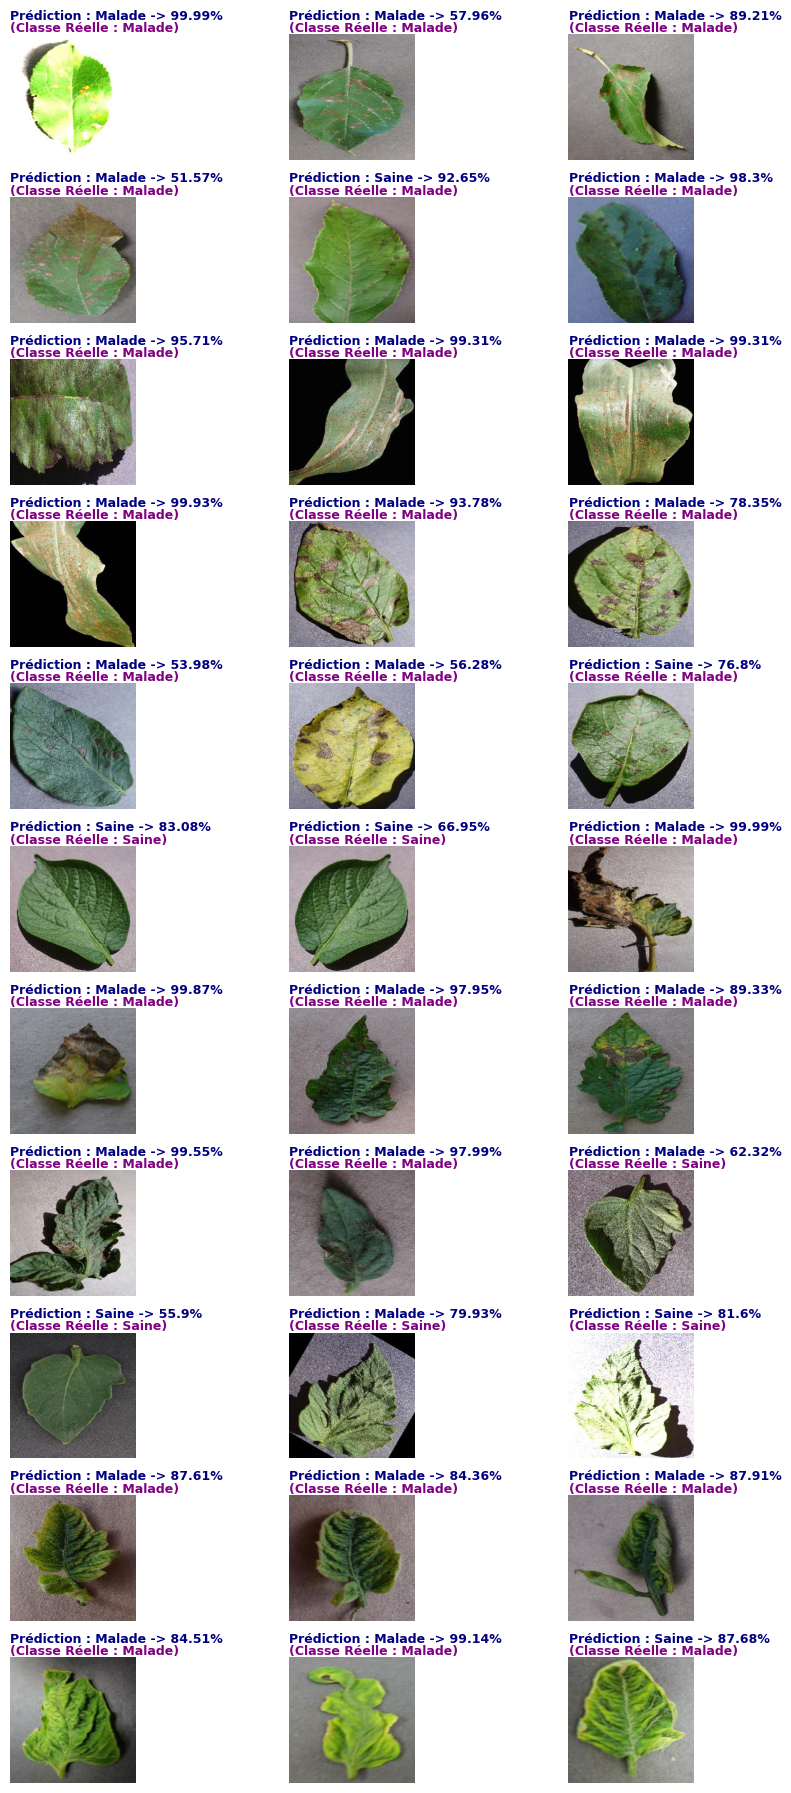

In [23]:
#Chemin du répertoire contenant les images
test_dir = r"C:\Users\flore\Jupyter\Recog_Plant_Disease\Datasets\NPD\test\Test___Pictures_Random"

#Obtention de la liste des noms de fichiers d'images
file_list = os.listdir(test_dir)

# Sélection des 33 fichiers d'images
selected_files = file_list[:33]

#Configuration des sous-plots
fig, axes = plt.subplots(11, 3, figsize=(9, 18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Boucle pour afficher les images
for i, file in enumerate(selected_files):
    file_path = os.path.join(test_dir, file)

    #Récupération de la classe réelle (via le nom du fichier)
    if "Healthy" in file:
        real_class = 'Saine'
    else:
        real_class = 'Malade'

    #Chargement et prétraitement de l'image
    test_image = image.load_img(file_path, target_size=(224, 224))
    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)

    #Prédiction de la classe sans affichage
    proba = round(100 * classifier.predict(test_image, verbose=0)[0][1], 2)
    if proba < 50:
        plant_state = 'Malade'
        proba = round(100 - proba, 2)
    else:
        plant_state = 'Saine'

    #Chargement et affichage de l'image
    img = mpimg.imread(file_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.text(0, -30, 'Prédiction : ' + plant_state + ' -> ' + str(proba) + '%', color='navy', fontsize=9, fontweight='bold')
    ax.text(0, -5, '(Classe Réelle : ' + real_class + ')', color='purple', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## V. Enregistrement du modèle

In [24]:
today = date.today()
today = today.strftime("%Y-%m-%d")

#Sauvegarde du modèle complet
f_savename = cwd + "\\Saved Models\\Xception-Pre_Final-Full_Model-" + today + ".h5"
classifier.save(f_savename)

#Sauvegarde des meilleurs poids du modèle
w_savename = cwd + "\\Saved Models\\Xception-Pre_Final-Best_Weights-" + today + ".h5"
classifier.save_weights(w_savename)